## QUBO Warm‑Start for the Battery MILP (24‑qubit discharge‑timing skeleton)
_A detailed tutorial on constructing a QUBO suitable for QAOA that produces an initial battery discharge schedule._

### Goal
The full battery optimization problem (joint operation of wind + battery) is mixed‑integer and nonlinear, mainly because:
- You must decide when to charge or discharge.
- SOC evolves deterministically.
- Power and energy constraints couple decisions across time.
- There are cycle and operational limits.

Solving the full MILP from a cold start may be slow or get stuck in poor branches.
A quantum warm-start uses QAOA to suggest a binary discharge timing skeleton, after which the classical solver fills in:
- exact charge/discharge magnitudes $c_t$,$d_t$​
- SOC trajectory $E_t$
- feasibility under limits
- best revenue

To keep the quantum circuit small and NISQ‑friendly, we isolate only the 24 binary timing decisions, one per hour.

We want a small QUBO (≤ 24 binary variables) that provides an initial guess for the discharge profile $d_t$, which can then be refined by a classical LP/MILP that enforces SOC dynamics and all engineering constraints.

Because of the no netting rule, the wind-scenario revenue term is constant w.r.t. battery decisions, so the battery schedule is driven by prices $p_t$ (and battery constraints). The QUBO therefore uses only $p_t$.

---

## Step 1 — Skeleton decision variables (24 qubits)

Define one binary variable per hour: $x_t \in \{0,1\}$ for $t=1,\dots,24$.

Interpretation:
- $x_t=1$ means “discharge during hour $t$”
- $x_t=0$ means “do not discharge during hour $t$”

To keep the QUBO minimal, we use a coarse discharge magnitude:
$\tilde d_t := 4x_t$ (MWh).

This yields a binary timing skeleton for discharge, which is the warm-start signal we want.

---

## Step 2 — Revenue term in QUBO form

Battery discharge revenue under the skeleton approximation is:
$\sum_{t=1}^{24} p_t \tilde d_t = \sum_{t=1}^{24} 4p_t x_t$.

A QUBO is typically a minimization, so we minimize negative revenue:
$E_{\mathrm{rev}}(x) := -\sum_{t=1}^{24} 4p_t x_t$.

---

## Step 3 — Continuity via a switching penalty

To discourage fragmented on/off behavior, add a quadratic penalty on switches:
$E_{\mathrm{sw}}(x) := \gamma \sum_{t=2}^{24} (x_t-x_{t-1})^2$, with $\gamma\ge 0$.

For binary variables, $x_t^2=x_t$, hence:
$(x_t-x_{t-1})^2 = x_t + x_{t-1} - 2x_tx_{t-1}$.

Interpretation:
- $\gamma$ acts like a cost per switch (up to scaling)
- larger $\gamma$ encourages fewer discharge blocks

---

## Step 4 — Cycle proxy as a cardinality penalty (no extra qubits)

The MILP cycle proxy is:
$\sum_{t=1}^{24} d_t \le 32$ MWh.

Under $\tilde d_t=4x_t$, this becomes:
$4\sum_{t=1}^{24} x_t \le 32$, i.e. $\sum_{t=1}^{24} x_t \le 8$.

With only 24 qubits, a standard way to enforce this without slack bits is a target-cardinality penalty:
$E_{\mathrm{card}}(x) := A\left(\sum_{t=1}^{24} x_t - K\right)^2$, with $A>0$ and $K=8$.

Notes:
- This enforces $\sum_t x_t \approx K$ (typically $\sum_t x_t = K$ if $A$ is large).
- This is a modification of the original inequality, acceptable for warm-starting because the classical refinement step will enforce SOC physics and may reshape discharges.

---

## Step 5 — Final QUBO objective

The final QUBO is:
$\min_{x\in\{0,1\}^{24}} E(x)$

with:
$E(x)=E_{\mathrm{rev}}(x)+E_{\mathrm{sw}}(x)+E_{\mathrm{card}}(x)$

i.e.:
$E(x)=-\sum_{t=1}^{24}4p_t x_t + \gamma\sum_{t=2}^{24}(x_t-x_{t-1})^2 + A\left(\sum_{t=1}^{24}x_t-K\right)^2$.

This uses exactly 24 binary variables.

---

## Step 6 — QUBO matrix form $x^\top Q x$

Write $x=(x_1,\dots,x_{24})^\top$. A QUBO can be written as:
$E(x)=x^\top Q x$,

using the convention:
$x^\top Q x = \sum_t Q_{tt}x_t + \sum_{i<j} Q_{ij}x_ix_j$.

### Diagonal terms (linear coefficients)

Define:
$\deg(t)=1$ for $t\in\{1,24\}$, and $\deg(t)=2$ for $t\in\{2,\dots,23\}$.

Then:
$Q_{tt} = -4p_t + \gamma\,\deg(t) + A(1-2K)$.

### Off-diagonal terms (quadratic couplers)

Cardinality penalty contributes for all $i<j$:
$Q_{ij} \mathrel{+}= 2A$.

Switching penalty contributes for adjacent hours:
$Q_{t-1,t} \mathrel{+}= -2\gamma$ for $t=2,\dots,24$.

Equivalently:
- if $|i-j|=1$, then $Q_{ij}=2A-2\gamma$
- if $|i-j|>1$, then $Q_{ij}=2A$

(Additive constants such as $AK^2$ can be dropped since they do not affect the minimizer.)


Let us start with importing all the librabries we are using:

In [1]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
# from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
import numpy as np
from qiskit.circuit.library import XXPlusYYGate
import qiskit

from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import matplotlib.pyplot as plt
backend = FakeSherbrooke()


import numpy as np
import pandas as pd

In [2]:
# Load dataset
df = pd.read_csv("../data/input_data.csv")
p = df["price"].to_numpy()

# Parameters used for the 24-qubit QUBO
A = 1000.0
gamma = 100.0
K = 8

def build_qubo_upper(p, A=1000.0, gamma=100.0, K=8):
    p=np.asarray(p,float); n=len(p)
    Q=np.zeros((n,n),float)
    # revenue (discharge at 4 MWh when x_t=1)
    for t in range(n):
        Q[t,t] += -4.0*p[t]
    # switching penalty gamma * sum_{t=2..24} (x_t - x_{t-1})^2
    for t in range(n):
        deg = 1.0 if (t==0 or t==n-1) else 2.0
        Q[t,t] += gamma*deg
    for t in range(1,n):
        Q[t-1,t] += -2.0*gamma  # only upper triangle
    # cardinality penalty A*(sum x - K)^2, constant A*K^2 omitted
    lin=A*(1-2*K)
    for t in range(n):
        Q[t,t] += lin
    for i in range(n):
        for j in range(i+1,n):
            Q[i,j] += 2.0*A
    return Q

def upper_to_symmetric(Q_upper):
    Q_sym = np.array(Q_upper, float)
    n=Q_sym.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            q=Q_sym[i,j]
            Q_sym[i,j]=q/2.0
            Q_sym[j,i]=q/2.0
    return Q_sym

Q_upper = build_qubo_upper(p, A=A, gamma=gamma, K=K)
Q_sym = upper_to_symmetric(Q_upper)

# Solve exactly (dynamic programming over time and number of 1s; exact for this special structure)
def solve_chain_with_count(p, gamma, m):
    T=len(p)
    C = -2.0*gamma
    L = np.zeros(T)
    for t in range(T):
        deg = 1.0 if (t==0 or t==T-1) else 2.0
        L[t] = -4.0*p[t] + gamma*deg
    
    INF=1e30
    dp = np.full((T, m+1, 2), INF)
    prev = np.full((T, m+1, 2), -1, dtype=int)
    for s in (0,1):
        k=s
        if k<=m:
            dp[0,k,s]=L[0]*s
            prev[0,k,s]=-1
    for t in range(1,T):
        for k in range(m+1):
            for s in (0,1):
                if k - s < 0:
                    continue
                best=INF; best_prev=-1
                for sp in (0,1):
                    val = dp[t-1, k-s, sp]
                    if val>=INF/2: 
                        continue
                    val2 = val + L[t]*s + C*sp*s
                    if val2 < best:
                        best = val2
                        best_prev = sp
                dp[t,k,s]=best
                prev[t,k,s]=best_prev
    s_final = int(dp[T-1,m,1] < dp[T-1,m,0])
    Emin = dp[T-1,m,s_final]
    x = np.zeros(T,dtype=int)
    k=m; s=s_final
    for t in range(T-1,-1,-1):
        x[t]=s
        sp=prev[t,k,s]
        k-=s
        s=sp if sp!=-1 else 0
    return Emin, x

def solve_qubo_skeleton(p, A, gamma, K):
    T=len(p)
    best_E=1e30
    best_x=None
    best_m=None
    for m in range(T+1):
        chain_E, x = solve_chain_with_count(p, gamma, m)
        E = chain_E + A*(m-K)**2
        if E < best_E:
            best_E=E; best_x=x; best_m=m
    return best_E, best_m, best_x

E_opt, m_opt, x_opt = solve_qubo_skeleton(p, A=A, gamma=gamma, K=K)
d0 = 4.0*x_opt

# Diagonalization (eigendecomposition) of the symmetric form
eigvals, eigvecs = np.linalg.eigh(Q_sym)

# Save artifacts
Q_upper_df = pd.DataFrame(Q_upper, index=[f"h{t}" for t in range(1,25)], columns=[f"h{t}" for t in range(1,25)])
Q_sym_df   = pd.DataFrame(Q_sym,   index=[f"h{t}" for t in range(1,25)], columns=[f"h{t}" for t in range(1,25)])

sol_df = df[["hour","price"]].copy()
sol_df["x_discharge"] = x_opt
sol_df["d0_MWh"] = d0

Q_upper_path = "../data/qubo_matrix_upper.csv"
Q_sym_path   = "../data/qubo_matrix_symmetric.csv"
sol_path     = "../data/qubo_solution.csv"

Q_upper_df.to_csv(Q_upper_path, float_format="%.6f")
Q_sym_df.to_csv(Q_sym_path, float_format="%.6f")
sol_df.to_csv(sol_path, index=False)

# Display small summaries
summary = pd.DataFrame({
    "parameter": ["A", "gamma", "K", "m_opt (sum x)", "E_opt (includes A*(m-K)^2)", "switches", "approx_discharge_revenue_EUR"],
    "value": [A, gamma, K, int(m_opt), float(E_opt), int(np.sum(x_opt[1:] != x_opt[:-1])), float(np.sum(4*p*x_opt))]
})

print("QUBO parameter summary", summary)
print("QUBO solution (x and d0 per hour)", sol_df)

eig_summary = pd.DataFrame({
    "eigval": eigvals
})
print("Eigenvalues of Q (symmetric form)", eig_summary.head(10))



QUBO parameter summary                       parameter    value
0                             A  1000.00
1                         gamma   100.00
2                             K     8.00
3                 m_opt (sum x)     8.00
4    E_opt (includes A*(m-K)^2) -3681.96
5                      switches     3.00
6  approx_discharge_revenue_EUR  3981.96
QUBO solution (x and d0 per hour)     hour   price  x_discharge  d0_MWh
0      1   88.96            0     0.0
1      2   83.82            0     0.0
2      3   83.00            0     0.0
3      4   82.56            0     0.0
4      5   82.82            0     0.0
5      6   86.01            0     0.0
6      7  103.21            0     0.0
7      8  133.09            1     4.0
8      9  113.73            1     4.0
9     10   70.89            0     0.0
10    11   34.14            0     0.0
11    12   19.97            0     0.0
12    13   16.49            0     0.0
13    14   13.72            0     0.0
14    15   18.62            0     0.0
15    1

## Step 7 — Use QAOA to solve the QUBO and warm-start the MILP

After solving the QUBO, decode the binary solution $x_t^\star$ and define:
$d_t^{(0)} := 4x_t^\star$.

Then run a classical projection/refinement that enforces the real battery physics:
- SOC dynamics: $E_t = E_{t-1} + \eta_{\mathrm{ch}}c_t - d_t$, with $E_0=E_{24}=0$ and $0\le E_t\le 16$
- power limits: $0\le c_t\le 5$ and $0\le d_t\le 4$
- optionally: no-reversal and/or block penalties

A typical refinement approach is:
1. Fix or encourage discharge in the hours where $x_t^\star=1$ (e.g., bounds or a deviation penalty $\sum_t |d_t-d_t^{(0)}|$).
2. Solve the resulting LP/MILP to obtain a feasible $(c_t,d_t,E_t)$.
3. Use that solution as the warm start / incumbent for the full MILP.

Pipeline summary:
$\text{MILP} \Rightarrow \text{QUBO skeleton (24 qubits)} \Rightarrow \text{LP/MILP projection} \Rightarrow \text{full MILP}$.

In [3]:
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Example QUBO
Q = (pd.read_csv("../data/qubo_matrix_symmetric.csv",index_col = 0).to_numpy())

In [5]:
# Create QuadraticProgram
qp = QuadraticProgram()
n = Q.shape[0]
for i in range(n):
    qp.binary_var(name=f'x{i}')

# Add quadratic objective
objective = {}
for i in range(n):
    for j in range(n):
        if Q[i, j] != 0:
            objective[(f'x{i}', f'x{j}')] = Q[i, j]

qp.minimize(quadratic=objective)
# Convert to Ising operator
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
operator, offset = qubo.to_ising()

In [6]:
circuit = QAOAAnsatz(cost_operator=operator, reps=1)
circuit.measure_all()

In [7]:
circuit.draw(fold = -1)

┌───────────────────┐ ░ ┌─┐                                                                     
    q_0: ┤0                  ├─░─┤M├─────────────────────────────────────────────────────────────────────
         │                   │ ░ └╥┘┌─┐                                                                  
    q_1: ┤1                  ├─░──╫─┤M├──────────────────────────────────────────────────────────────────
         │                   │ ░  ║ └╥┘┌─┐                                                               
    q_2: ┤2                  ├─░──╫──╫─┤M├───────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║ └╥┘┌─┐                                                            
    q_3: ┤3                  ├─░──╫──╫──╫─┤M├────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║ └╥┘┌─┐                                                         
    q_4: ┤4                  ├─░──╫──╫──╫──╫─┤M├─────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║ └╥┘┌─┐                                                      
    q_5: ┤5                  ├─░──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                                                   
    q_6: ┤6                  ├─░──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                
    q_7: ┤7                  ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                             
    q_8: ┤8                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                          
    q_9: ┤9                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                       
   q_10: ┤10                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                    
   q_11: ┤11                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────
         │   QAOA(γ[0],β[0]) │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                 
   q_12: ┤12                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                              
   q_13: ┤13                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                           
   q_14: ┤14                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
   q_15: ┤15                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     
   q_16: ┤16                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  
   q_17: ┤17                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               
   q_18: ┤18                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─

In [8]:
def cost_fun_estimator(params, ansatz, hamiltonian, estimator):
    # we map the hamiltonian to the device
    isa_hamiltonian = hamiltonian.apply_layout(layout=ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)

    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)

    return cost

from qiskit_aer import AerSimulator
backend_aer = AerSimulator()
print(backend_aer)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_aer)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw(fold=-1)



AerSimulator('aer_simulator')


/Users/yanislefur/Documents/IQM_Hackathon/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


┌───┐┌─────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [9]:
from scipy.optimize import minimize

init_gamma = 0.05
init_beta = 0.01

init_params = [init_gamma, init_beta]*circuit.reps

objective_func_vals = [] 
with Session(backend=backend_aer) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1024

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(candidate_circuit, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':40, 'disp':True}
                         )

print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5965.525234375
       x: [-6.126e-01  1.759e+00]
    nfev: 27
   maxcv: 0.0
   Normal return from subroutine COBYLA

   NFVALS =   27   F =-5.965525E+03    MAXCV = 0.000000E+00
   X =-6.126101E-01   1.759273E+00



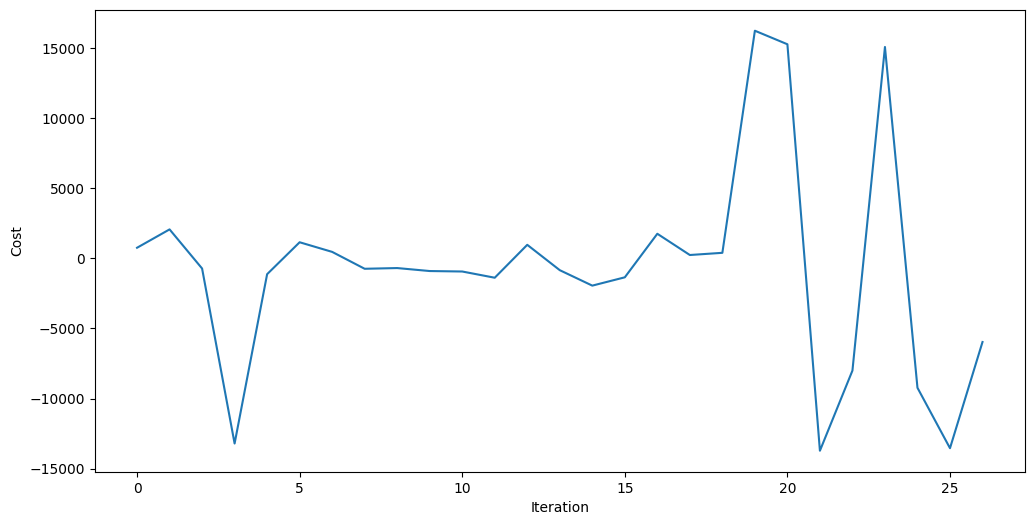

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)

sampler = Sampler(mode=backend_aer)
sampler.options.default_shots = 100_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{2764712: 0.00021, 11021224: 2e-05, 7091628: 0.0001, 16259720: 1e-05, 2903498: 1e-05, 4751276: 1e-05, 7109772: 1e-05, 3034924: 2e-05, 6860708: 4e-05, 2363300: 2e-05, 11284236: 2e-05, 5793711: 1e-05, 10043297: 1e-05, 2375588: 0.00022, 2895656: 0.00076, 7090088: 0.00073, 2440998: 1e-05, 2625452: 0.00012, 2629005: 1e-05, 2624934: 2e-05, 6897056: 7e-05, 3522440: 1e-05, 1916576: 1e-05, 2899752: 0.00094, 11300014: 2e-05, 3043208: 3e-05, 2109090: 1e-05, 3739424: 2e-05, 3948393: 1e-05, 2895140: 8e-05, 4006: 1e-05, 2899360: 0.00079, 7282088: 2e-05, 2961288: 0.00012, 2895788: 0.00183, 11280172: 4e-05, 11320740: 2e-05, 895469: 1e-05, 7290272: 2e-05, 2885418: 1e-05, 2633512: 0.00042, 8128288: 2e-05, 3095982: 3e-05, 2957216: 0.00018, 3944352: 0.00051, 3686152: 4e-05, 2906080: 1e-05, 6979104: 1e-05, 3030828: 0.00013, 2404200: 1e-05, 2633608: 0.00012, 15629988: 1e-05, 2633572: 4e-05, 11321100: 1e-05, 2633518: 6e-05, 7090108: 4e-05, 634766: 1e-05, 4136741: 1e-05, 3031008: 9e-05, 2703212: 4e-05, 394371

In [12]:
max_key = max(final_distribution_int, key=final_distribution_int.get)
max_value = final_distribution_int[max_key]
print("max_key:", max_key)
print("max_value:", max_value)
# show as binary string (n is already defined)
print("binary:", format(max_key, f'0{n}b'))

max_key: 2895784
max_value: 0.00241
binary: 001011000010111110101000


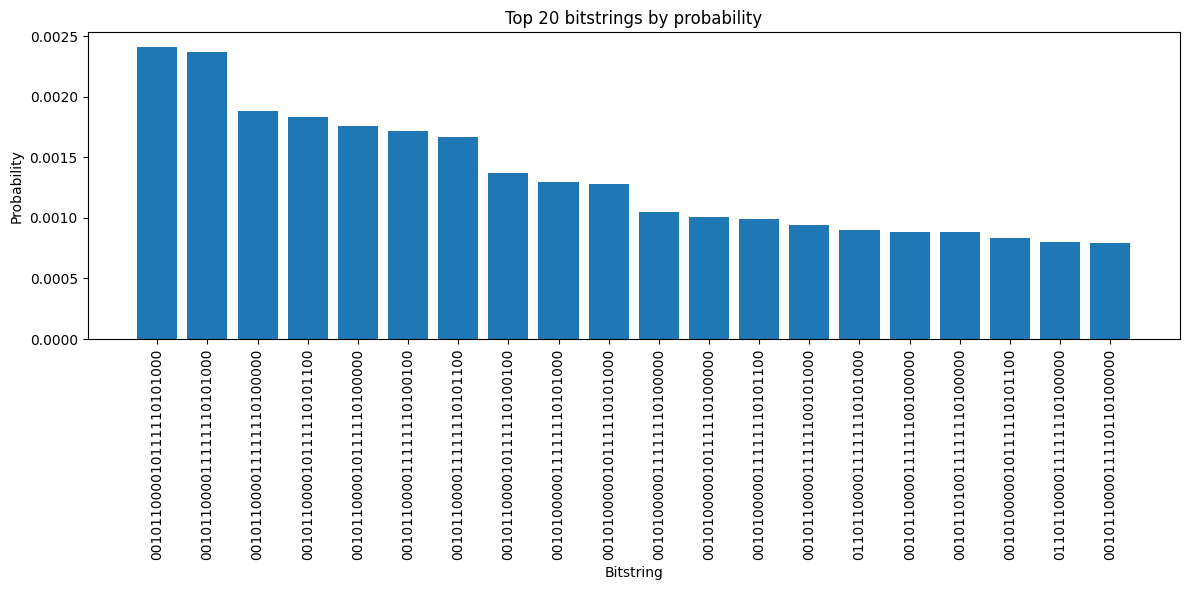

In [13]:
# plot top 20 bitstrings by probability
top_k = 20
items = sorted(final_distribution_int.items(), key=lambda kv: kv[1], reverse=True)[:min(top_k, len(final_distribution_int))]
if not items:
    print("No distribution to plot.")
else:
    ints, probs = zip(*items)
    bins = [format(k, f'0{n}b') for k in ints]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bins)), probs)
    plt.xticks(range(len(bins)), bins, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"Top {len(bins)} bitstrings by probability")
    plt.tight_layout()
    plt.show()

## IQM Resonance
Now let us actually run the QAOA on IQM's hardware.

In [14]:
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com/", quantum_computer="emerald",
            token=input("8eU6b8R4eIqRLjHavNKc4eS3ThzJk4vx9Pp28vToNxUBmxvSHPh84pcO0KSVMKVk"))
backend_hardware = provider.get_backend()

In [15]:
candidate_circuit.draw(fold = -1)

┌───┐┌─────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [16]:
import qiskit 
qc_transpiled = qiskit.transpile(
  candidate_circuit,            
  layout_method='sabre',
  backend=backend_hardware,
  optimization_level=3,
)
  
qc_transpiled.draw(fold = -1)

┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ┌──────────┐                          ┌──────────┐                             ┌──────────┐                        ┌──────────┐                                       ┌──────────┐                                          ┌──────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [17]:
from scipy.optimize import minimize

init_gamma = 0.05
init_beta = 0.01

init_params = [init_gamma, init_beta]*circuit.reps

objective_func_vals = [] 
with Session(backend=backend_hardware) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 20_000

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(qc_transpiled, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':3, 'disp':True}
                         )
    
print(result)
                      


/Users/yanislefur/Documents/IQM_Hackathon/venv/lib/python3.11/site-packages/iqm/qiskit_iqm/iqm_provider.py:191: UserWarning: Unknown backend option(s): {'seed_simulator': None}
  warnings.warn(f"Unknown backend option(s): {unknown_options}")
Progress in queue:   0%|          | 0/1 [00:01<?, ?it/s]
Job failed! Error(s):
  iqm-server: declined: Not enough credits to execute job


KeyError: ((), 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII')

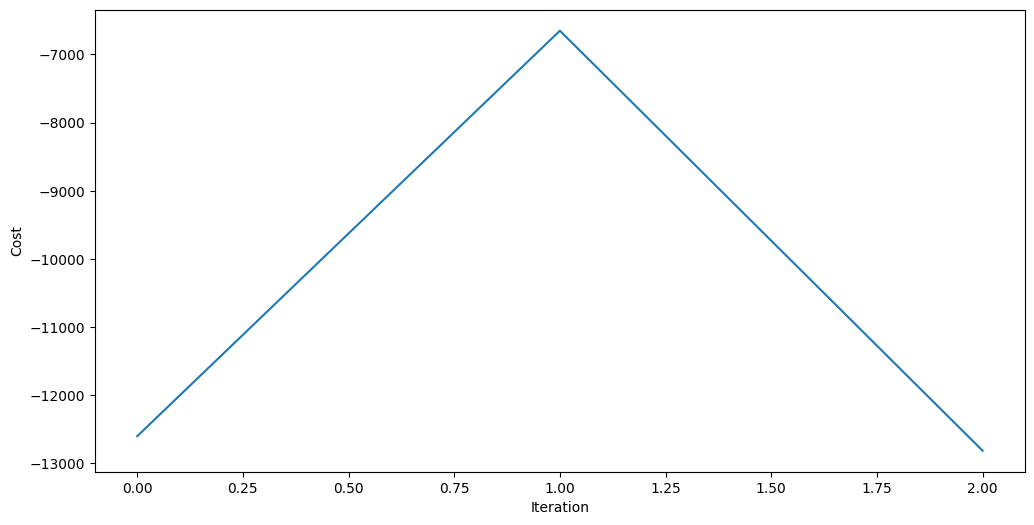

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = qc_transpiled.assign_parameters(result.x)

sampler = Sampler(mode=backend_aer)
sampler.options.default_shots = 100_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{16273304: 1e-05, 13628346: 1e-05, 16399726: 1e-05, 7975908: 1e-05, 5318042: 1e-05, 1912136: 1e-05, 2974112: 1e-05, 9866619: 1e-05, 299934: 1e-05, 5141237: 1e-05, 4868112: 1e-05, 870314: 1e-05, 3059450: 1e-05, 10162511: 1e-05, 12645831: 1e-05, 5993076: 1e-05, 1842800: 1e-05, 13912880: 1e-05, 1703049: 1e-05, 3699950: 1e-05, 6382733: 1e-05, 13171780: 1e-05, 6347824: 1e-05, 3464293: 1e-05, 2300236: 1e-05, 4840681: 1e-05, 5575820: 1e-05, 481402: 1e-05, 2494264: 1e-05, 8806486: 1e-05, 4801559: 1e-05, 13318120: 1e-05, 5696054: 1e-05, 12351957: 1e-05, 121251: 1e-05, 8692336: 1e-05, 2801770: 1e-05, 7045462: 1e-05, 11005791: 1e-05, 14790686: 1e-05, 13242787: 1e-05, 9537526: 1e-05, 11871596: 1e-05, 12183751: 1e-05, 3956059: 1e-05, 6568758: 1e-05, 16555352: 1e-05, 4706339: 1e-05, 6717618: 1e-05, 6626301: 1e-05, 6767709: 1e-05, 4539759: 1e-05, 2639957: 1e-05, 8674147: 1e-05, 12479112: 1e-05, 7401139: 1e-05, 12922874: 1e-05, 2094743: 1e-05, 4627640: 1e-05, 13841530: 1e-05, 2381239: 1e-05, 11648032:

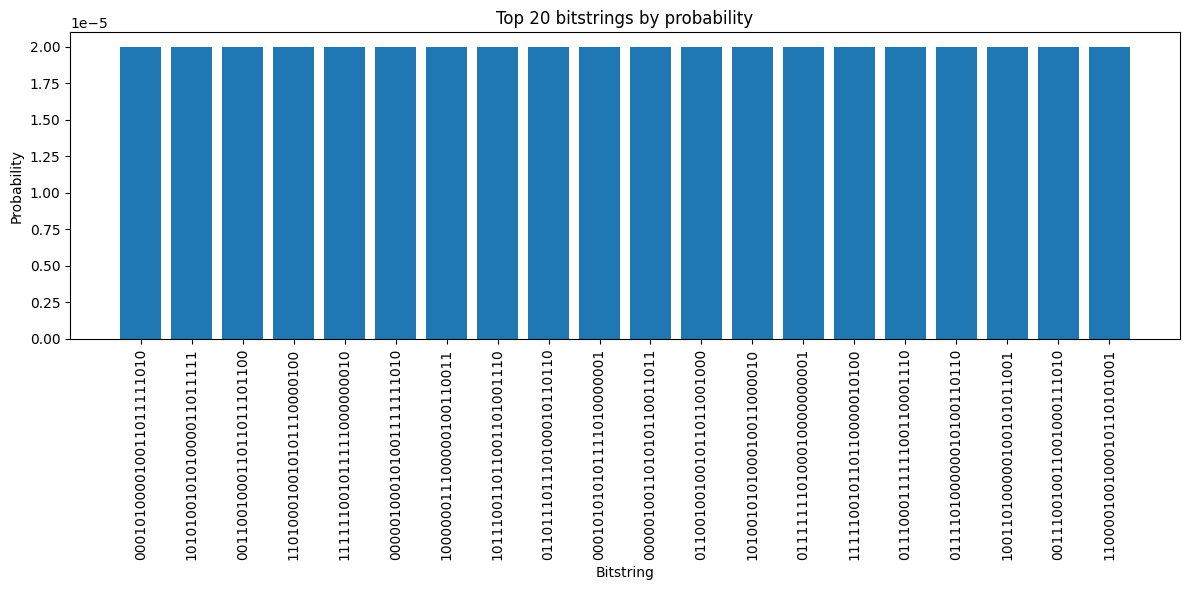

In [ ]:
# plot top 20 bitstrings by probability
top_k = 20
items = sorted(final_distribution_int.items(), key=lambda kv: kv[1], reverse=True)[:min(top_k, len(final_distribution_int))]
if not items:
    print("No distribution to plot.")
else:
    ints, probs = zip(*items)
    bins = [format(k, f'0{n}b') for k in ints]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bins)), probs)
    plt.xticks(range(len(bins)), bins, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"Top {len(bins)} bitstrings by probability")
    plt.tight_layout()
    plt.show()